In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ignore imputation warnings from pymc
# ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
import warnings
from pymc import ImputationWarning

warnings.filterwarnings("ignore", category=ImputationWarning)

In [54]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from birdcall_distribution.geo import (
    get_western_us_geometry,
    generate_grid,
    add_lonlat_columns,
    generate_grid_adjaceny_list,
    WESTERN_US_EXTENT,
    get_adjacency_mapping,
    convert_to_adjacency_matrix,
)
from sklearn.preprocessing import StandardScaler


# dataset with our data from earth engine
ee_df = pd.read_parquet("../data/ee_v3_western_us_2.parquet")
grid_size = ee_df.grid_size.values[0]

geometry = get_western_us_geometry()
grid = generate_grid(geometry, WESTERN_US_EXTENT, (grid_size, grid_size))
adjacency_list = generate_grid_adjaceny_list(grid)
mapping = get_adjacency_mapping(adjacency_list)
W = convert_to_adjacency_matrix(adjacency_list)

# pull out species and longitude/latitude data from the kaggle dataset
df = pd.read_csv("../data/raw/birdclef-2022/train_metadata.csv")
df = df[["primary_label", "latitude", "longitude"]].dropna()
df = add_lonlat_columns(df, grid)
df = df[df.grid.notnull()]
df["adjacency_idx"] = df.grid_id.apply(lambda x: mapping.get(x, None))

# now modify the species list so we only keep the top n
n = 10
top_n = (
    df[["primary_label"]]
    .groupby("primary_label")
    .value_counts()
    .sort_values(ascending=False)[:n]
)
df["primary_label"] = df.primary_label.apply(
    lambda x: x if x in top_n.index else "other"
)

# count number of observed calls per adjacency index, and join against the ee variables
group_cols = ["primary_label", "grid_id"]
counts_df = df[group_cols].groupby(group_cols).value_counts().reset_index()
counts_df.columns = group_cols + ["y"]

prep_df = counts_df.merge(
    ee_df.rename(columns={"name": "grid_id"}), on="grid_id", how="outer"
)
prep_df["adjacency_idx"] = prep_df.grid_id.apply(lambda x: mapping.get(x, None))
prep_df = prep_df.set_index("adjacency_idx").sort_index()
prep_df

,primary_label,grid_id,y,region,grid_size,population_density,elevation_p5,elevation_p50,elevation_p95,LST_Day_1km_p5,...,land_cover_08,land_cover_09,land_cover_10,land_cover_11,land_cover_12,land_cover_13,land_cover_14,land_cover_15,land_cover_16,land_cover_17
adjacency_idx,,,,,,,,,,,,,,,,,,,,,
0,normoc,-103_37,3.0,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,norcar,-103_37,7.0,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,other,-103_37,1.0,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,towsol,-103_37,1.0,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,wesmea,-103_37,2.0,western_us,2,5.951349e+04,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,other,-125_45,14.0,western_us,2,5.864267e+05,0.046563,0.046563,517.441176,13.368653,...,1005,298,242,151,906,83,89,0,1,2996
95,wesmea,-125_47,3.0,western_us,2,1.094765e+06,0.438378,103.526808,1143.404496,9.175678,...,297,57,301,151,18,170,0,19,61,5499
95,other,-125_47,55.0,western_us,2,1.094765e+06,0.438378,103.526808,1143.404496,9.175678,...,297,57,301,151,18,170,0,19,61,5499


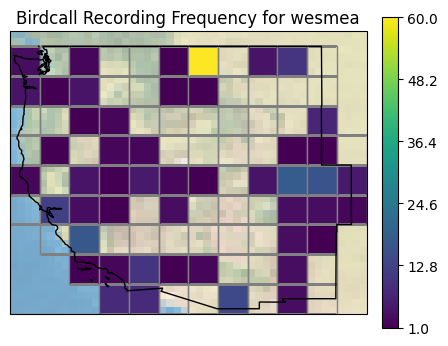

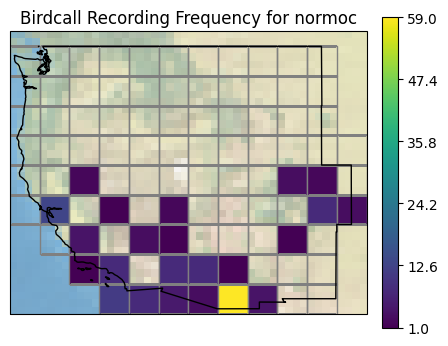

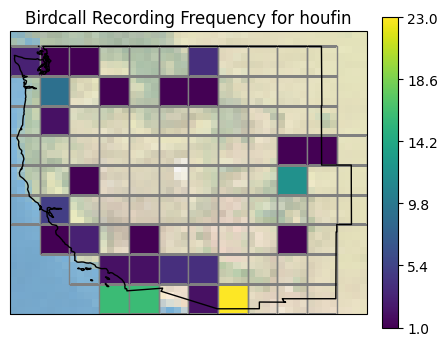

In [55]:
from birdcall_distribution.plot import dataframe_color_getter, plot_grid
from functools import partial


def plot_species(df, species, prop="y"):
    sub_df = df[df.primary_label == species]
    plot_grid(
        geometry,
        WESTERN_US_EXTENT,
        grid,
        color_callback=partial(dataframe_color_getter, sub_df, "grid_id", prop),
        vmin=sub_df[prop].min(),
        vmax=sub_df[prop].max(),
        draw_gridline=False,
        figsize=(5, 7),
    )

    plt.title(f"Birdcall Recording Frequency for {species}")
    plt.show()


def plot_ppc(prep_df, ppc, prop="log_pred"):
    shape = prep_df.shape
    pred = ppc.posterior_predictive.y.values.reshape(-1, shape[0]).mean(axis=0)
    pred_df = pd.DataFrame({"pred": pred})
    pred_df["adjacency_idx"] = pred_df.index
    pred_df = pred_df.set_index("adjacency_idx").join(prep_df[["grid_id"]])
    # log prediction
    pred_df["log_pred"] = np.log(pred_df.pred)

    plt.figure(figsize=(5, 3))
    plt.hist(pred_df[prop], bins=20)
    plt.title(f"histogram of {prop}")
    plt.show()

    # plot the posterior predictive
    plot_grid(
        geometry,
        WESTERN_US_EXTENT,
        grid,
        color_callback=partial(dataframe_color_getter, pred_df, "grid_id", prop),
        vmin=pred_df[prop].min(),
        vmax=pred_df[prop].max(),
        draw_gridline=False,
        figsize=(5, 7),
    )
    plt.title("Birdcall Recording Frequency prediction")
    plt.show()


plot_species(prep_df, "wesmea")
plot_species(prep_df, "normoc")
plot_species(prep_df, "houfin")

## model

### varying intercept and slope

\begin{equation}
y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \epsilon_i
\end{equation}

## 

In [56]:
cols = prep_df.columns
temp_and_alt_cols = [c for c in cols if ("km" in c or "elevation" in c) and "50" in c]
temp_and_alt_cols

['elevation_p50', 'LST_Day_1km_p50', 'LST_Night_1km_p50']

In [114]:
scaler = StandardScaler()
data_cols = ["population_density"] + temp_and_alt_cols
temp_df = prep_df[data_cols].copy()

# add an intercept to the data cols
temp_df["intercept"] = 1
data_cols = ["intercept"] + data_cols

temp_df["population_density"] = np.log(temp_df["population_density"] + 1)
scaler.fit(temp_df)
scaled_data_df = pd.DataFrame(scaler.transform(temp_df), columns=data_cols)

In [125]:
species_cat.cat.codes

adjacency_idx
0      5
0      4
0      6
0      9
0     10
      ..
94     6
95    10
95     6
95     2
95     0
Length: 307, dtype: int8

In [160]:
species_cat = prep_df.primary_label.astype("category")
n_features = scaled_data_df.shape[1]
n_species = len(species_cat.cat.categories)
coords = dict(
    features_idx=np.arange(n_features),
    species_idx=sorted(species_cat.cat.codes.unique()),
    adj_idx=sorted(prep_df.index.unique()),
)
with pm.Model(coords=coords) as full_model:
    species_idx = pm.ConstantData("species_idx", species_cat.cat.codes)
    adj_idx = pm.ConstantData("adj_idx", prep_df.index.values)

    alpha = pm.Uniform("alpha", 0, 1)
    phi = pm.CAR("phi", mu=np.zeros(W.shape[0]), tau=1e-4, alpha=alpha, W=W)

    # NOTE: reparameterization trick
    # https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html
    mu_betas = pm.Normal("mu_betas", mu=0, sigma=1, shape=n_features)
    sigma_betas = pm.Exponential("sigma_betas", 1, shape=n_features)
    z_betas = pm.Normal(
        "z_betas",
        mu=0,
        sigma=1,
        shape=(n_features, n_species),
        dims=("features_idx", "species_idx"),
    )
    betas = pm.Deterministic("betas", mu_betas + z_betas * sigma_betas)
    mu = pm.math.exp(pm.math.dot(scaled_data_df, betas) + phi[adj_idx])

    observed = np.ma.masked_invalid(prep_df.y.values)
    pm.Poisson("y", mu=mu, observed=observed)

pm.model_to_graphviz(full_model)

ERROR (aesara.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (aesara.graph.rewriting.basic): node: Assert{msg=Could not broadcast dimensions}(ScalarConstant{11}, ScalarConstant{False})
ERROR (aesara.graph.rewriting.basic): TRACEBACK:
ERROR (aesara.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/anthony/Library/Caches/pypoetry/virtualenvs/birdcall-distribution-rSEegjyg-py3.10/lib/python3.10/site-packages/aesara/graph/rewriting/basic.py", line 1933, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/anthony/Library/Caches/pypoetry/virtualenvs/birdcall-distribution-rSEegjyg-py3.10/lib/python3.10/site-packages/aesara/graph/rewriting/basic.py", line 1092, in transform
    return self.fn(fgraph, node)
  File "/Users/anthony/Library/Caches/pypoetry/virtualenvs/birdcall-distribution-rSEegjyg-py3.10/lib/python3.10/site-packages/aesara/tensor/rewriting/basic.py", line 1142, in constant_folding
    required = t

AssertionError: Could not broadcast dimensions

In [131]:
with full_model:
    # trace_full = pm.sample(1000, target_accept=0.9)
    trace_full = pm.sample(10, tune=10, target_accept=0.9)

az.summary(trace_full, kind="stats", var_names=["~phi", "~y"])

Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, phi, mu_betas, sigma_betas, z_betas]
>Metropolis: [y_missing]


Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 18 seconds.


ValueError: conflicting sizes for dimension 'species_idx': length 5 on the data but length 12 on coordinate 'species_idx'

In [97]:
az.summary(trace_full, kind="stats", var_names=["~phi", "~y"])

,mean,sd,hdi_3%,hdi_97%
intercept,-2.272,6.055,-13.655,8.290
betas[0],2.721,4.761,-6.309,11.647
betas[1],3.217,7.972,-11.553,18.042
betas[2],0.343,8.770,-15.173,17.337
betas[3],2.944,11.284,-17.139,24.678
y_missing[0],0.042,0.348,0.000,0.000
y_missing[1],0.032,0.287,0.000,0.000
y_missing[2],0.188,1.237,0.000,0.000
y_missing[3],1.620,4.560,0.000,13.000
y_missing[4],0.132,0.713,0.000,0.000


Sampling: [y_observed]


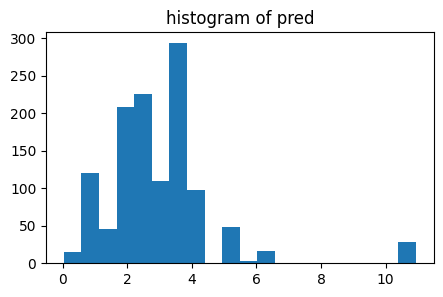

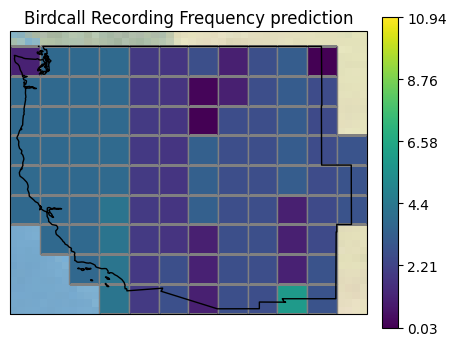

In [46]:
with full_model:
    ppc_full = pm.sample_posterior_predictive(trace_full)

plot_ppc(prep_df, ppc_full, "pred")